In [256]:
description='''
A specialized MCMC model for ITMY which has point absorbers.
'''


%matplotlib inline
from __future__ import division
import numpy as np
np.random.seed(123456789)   # repeatable results
import matplotlib.pyplot as pl
import matplotlib.mlab as mlab
import scipy.signal as sig
import scipy.constants as const
from scipy import interpolate
import corner
import emcee as mc
import pickle

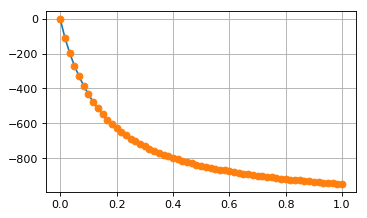

In [257]:
### Load comsol model for thermal lens
# Comsol model of the self heating
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model,fill_value="extrapolate")
    ynew = y(x)
    return a + (b * ynew)

a=0.0
b=1.0
x = np.arange(0,1,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.plot(time_model,-abs_model, 'o')
pl.grid()
pl.show()

In [258]:
# Best guess for ARM power
p_in=22
prc_g = 47.0
bs = 0.5
arm_g = 282.0

p_arm = p_in*prc_g*bs*arm_g

print('Estimated arm power is ',p_arm/1000,'kW')

Estimated arm power is  145.794 kW


In [259]:
### Best guess for ITM
amp1_guess_y  =  -0.8 #Starting Amplitude Guess
tau1_guess_y = 0.079 # Decay Time guess
print('amp1_model_y = ', amp1_guess_y, 'udiopters')
print('tau1_model_y = ', tau1_guess_y, 'hours')

amp2_guess_y  = -3.0 #Starting Amplitude Guess
tau2_guess_y = 0.021 # Decay Time guess
print('amp2_model_y = ', amp2_guess_y, 'diopters')
print('tau2_model_y = ', tau2_guess_y, 'hours')

amp1_model_y =  -0.8 udiopters
tau1_model_y =  0.079 hours
amp2_model_y =  -3.0 diopters
tau2_model_y =  0.021 hours


In [260]:
### Load the HWS Data
itmy = 'data_ITMY.p'

i_ind_y = 85
e_ind_y = -1
c_hori_y = 700
c_vert_y = 560

def open_file(filename):
    with open(str(filename), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data_p = u.load()
    return data_p

def format_data(optic, i_ind, e_ind, x, y):
    optic_data_p = open_file(optic)
    optic_data = optic_data_p[(x,y)]['spherical']
    
    data = optic_data[ i_ind:e_ind ]*1e6
    
    data = data - data[0]
    
    t_vect = np.arange(0.,float(len(data)),1.)
    t_vect = (t_vect)*20/3600 # Convert to Hours
    t_vect = t_vect - t_vect[0]
    
    return t_vect, data

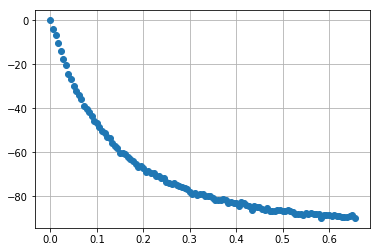

In [261]:
time_y, data_y = format_data(itmy, i_ind_y, e_ind_y, c_hori_y , c_vert_y)
pl.plot(time_y, data_y, 'o')
pl.grid()

In [289]:
"""# Define Log Likelihood
def lnprob(theta, t, signal, uncs) :
    amp1 = theta[0]
    tau1 = theta[1]
    amp2 = theta[2]
    tau2 = theta[3]
    
    if amp1 <= -20.0 or amp1 > 20.0 or tau1 <= 0.0 or tau1 > 0.1\
    or amp2 <= -20.0 or amp2 > 20.0 or tau2 <= 0.0 or tau2 > 0.05:
        return -np.inf
    else :
        new_signal = TL(t,amp1,tau1)+ TL(t,amp2,tau2)
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))
    """
# Define Log Likelihood
def lnprob(theta, t, signal, uncs) :
    amp1 = theta[0]
    tau1 = theta[1]
    amp2 = theta[2]
    tau2 = theta[3]
    
    if amp1 <= -50.0 or amp1 > 50.0 or tau1 <= 0.0 or tau1 > 0.1\
    or amp2 <= -50.0 or amp2 > 50.0 or tau2 <= 0.0 or tau2 > 0.05:
        return -np.inf
    else :
        new_signal = amp1*(1-np.exp(-t/tau1))+ amp2*(1-np.exp(-t/tau2))
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

In [294]:
def run_mcmc(t_vect, data, amp1_guess, tau1_guess, amp2_guess, tau2_guess):
    ndim = 4
    nwalkers = 100
    rr = np.transpose(np.vstack([np.random.normal(-2.0, 2.0, nwalkers),
                                 np.random.normal(0.0, 0.1, nwalkers),
                                 np.random.normal(-2.0, 2.0, nwalkers),
                                 np.random.normal(0.0, 0.05, nwalkers),
                                ]))
    
    p0 = np.tile(np.array([amp1_guess, tau1_guess, amp2_guess, tau2_guess]), (nwalkers,1)) + rr
    rr[0]

    samp = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=[t_vect, data, uncs])

    pos, prob, state = samp.run_mcmc(p0, 100)
    
    samp.reset()

    samp.run_mcmc(pos, 1000)
    
    print(len(samp.flatchain))

    results = np.copy(samp.flatchain) 
    
    return results

def plot_results(t_vect, signal, results,filename):
    amp1_mean, tau1_mean, amp2_mean, tau2_mean = np.mean(results,axis=0)
    amp1_medi, tau1_medi, amp2_medi, tau2_medi = np.median(results,axis=0)
    covmat = np.cov(results.T)
    amp1_unc, tau1_unc, amp2_unc, tau2_unc = np.sqrt(np.diag(covmat))
    print("Means            = ", amp1_mean,   tau1_mean, amp2_mean, tau2_mean )
    print("Medians          = ", amp1_medi,   tau1_medi, amp2_medi, tau2_medi )
    print("Uncertainties    = ", amp1_unc,    tau1_unc , amp2_unc,  tau2_unc  )
    print("Covariant Matrix = ", covmat)
    
    #arm_abs = 1e9*a_median/p_arm
    
    #print("ARM Absorption Estimate =  ",arm_abs, " [PPB]")
    
    exp1 = TL(t_vect,amp1_mean,tau1_mean)
    exp2 = TL(t_vect,amp2_mean,tau2_mean)
    
    recovered_exp = exp1 + exp2
    
    #xp1 = TL(t_vect,amp1_guess_y,tau1_guess_y)
    #exp2 = TL(t_vect,amp2_guess_y,tau2_guess_y)
    
    guess = TL(t_vect,amp1_guess_y,tau1_guess_y)+ TL(t_vect,amp2_guess_y,tau2_guess_y)
    
    pl.figure(figsize=(10, 5), dpi=300)
    pl.plot(t_vect, recovered_exp, '--', linewidth =3, label='Recovered exponential function')
    pl.plot(t_vect, signal, 'o', label='HWS Signal')
    pl.plot(t_vect, exp1,'-o',label = "EXP1")
    pl.plot(t_vect, exp2,'-o',label = "EXP2")
    pl.plot(t_vect, guess, label="GUESS")
    pl.legend(loc='best', fontsize=14)
    pl.xlabel('Time [Hours]', fontsize=14)
    pl.ylabel('Spherical Power [microdiopters]', fontsize=14)
    pl.tick_params(axis='both', labelsize =12)
    pl.grid()
    #pl.savefig("../../Figures/"+filename)"""

In [295]:
noise_std = 30.0
uncs = noise_std * np.ones(len(time_y))  # Uniform uncertainty in each point

#tau=0.05
#of = 5
#uncs=(80.0-offset)*np.exp(-np.linspace(0,time_y[-1],len(time_y))/tau)+of

results_y = run_mcmc(time_y, data_y, amp1_guess_y, tau1_guess_y, amp2_guess_y, tau2_guess_y)

C:\Users\tvo88\Anaconda3\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\tvo88\Anaconda3\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


100000


Quantiles:
[(0.16, -48.14524544592533), (0.5, -41.921963418856535), (0.84, -8.239217201070698)]
Quantiles:
[(0.16, 0.07254863385328583), (0.5, 0.09040157370464025), (0.84, 0.09888932826593934)]
Quantiles:
[(0.16, -41.93251559685452), (0.5, -33.78151922370037), (0.84, -8.818805441205546)]
Quantiles:
[(0.16, 0.024594250795140847), (0.5, 0.04166157965014523), (0.84, 0.04829147765793879)]


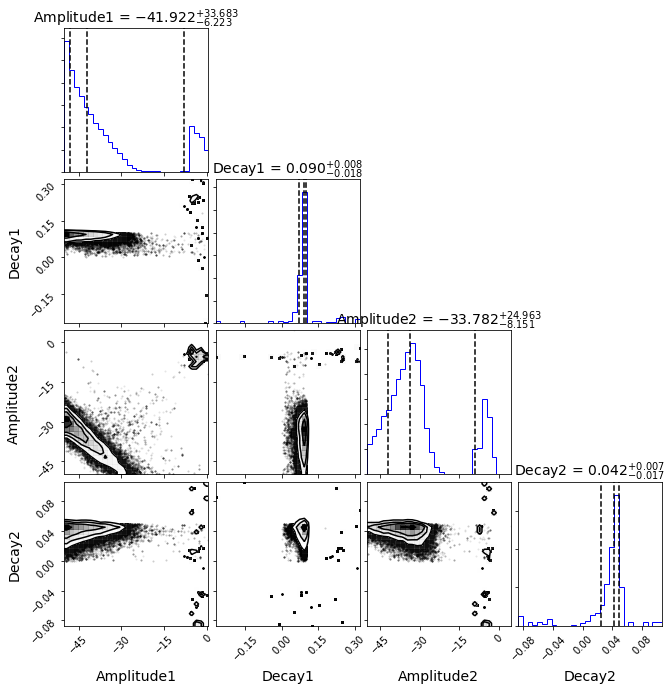

In [296]:
range_list = [ [-15, 20], [0.08, 0.135] ]
h_c = corner.corner(results_y, 
                    bins=30, 
                    labels=['Amplitude1', 'Decay1','Amplitude2','Decay2'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    #range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'}
                   )
#h_c.savefig("../../Figures/MCMC_ITMY_abs.png")

Means            =  -36.03273687230453 0.09170919569009874 -31.118496104390992 0.034014727258009116
Medians          =  -41.921963418856535 0.09040157370464025 -33.78151922370037 0.04166157965014523
Uncertainties    =  15.413852267169059 0.06837971934458997 12.55957728874366 0.030560369902784122
Covariant Matrix =  [[ 2.37586842e+02  1.47486784e-01  1.36137644e+02 -1.86529719e-01]
 [ 1.47486784e-01  4.67578602e-03  1.57966068e-01 -2.40456047e-04]
 [ 1.36137644e+02  1.57966068e-01  1.57742982e+02 -1.58042717e-01]
 [-1.86529719e-01 -2.40456047e-04 -1.58042717e-01  9.33936209e-04]]


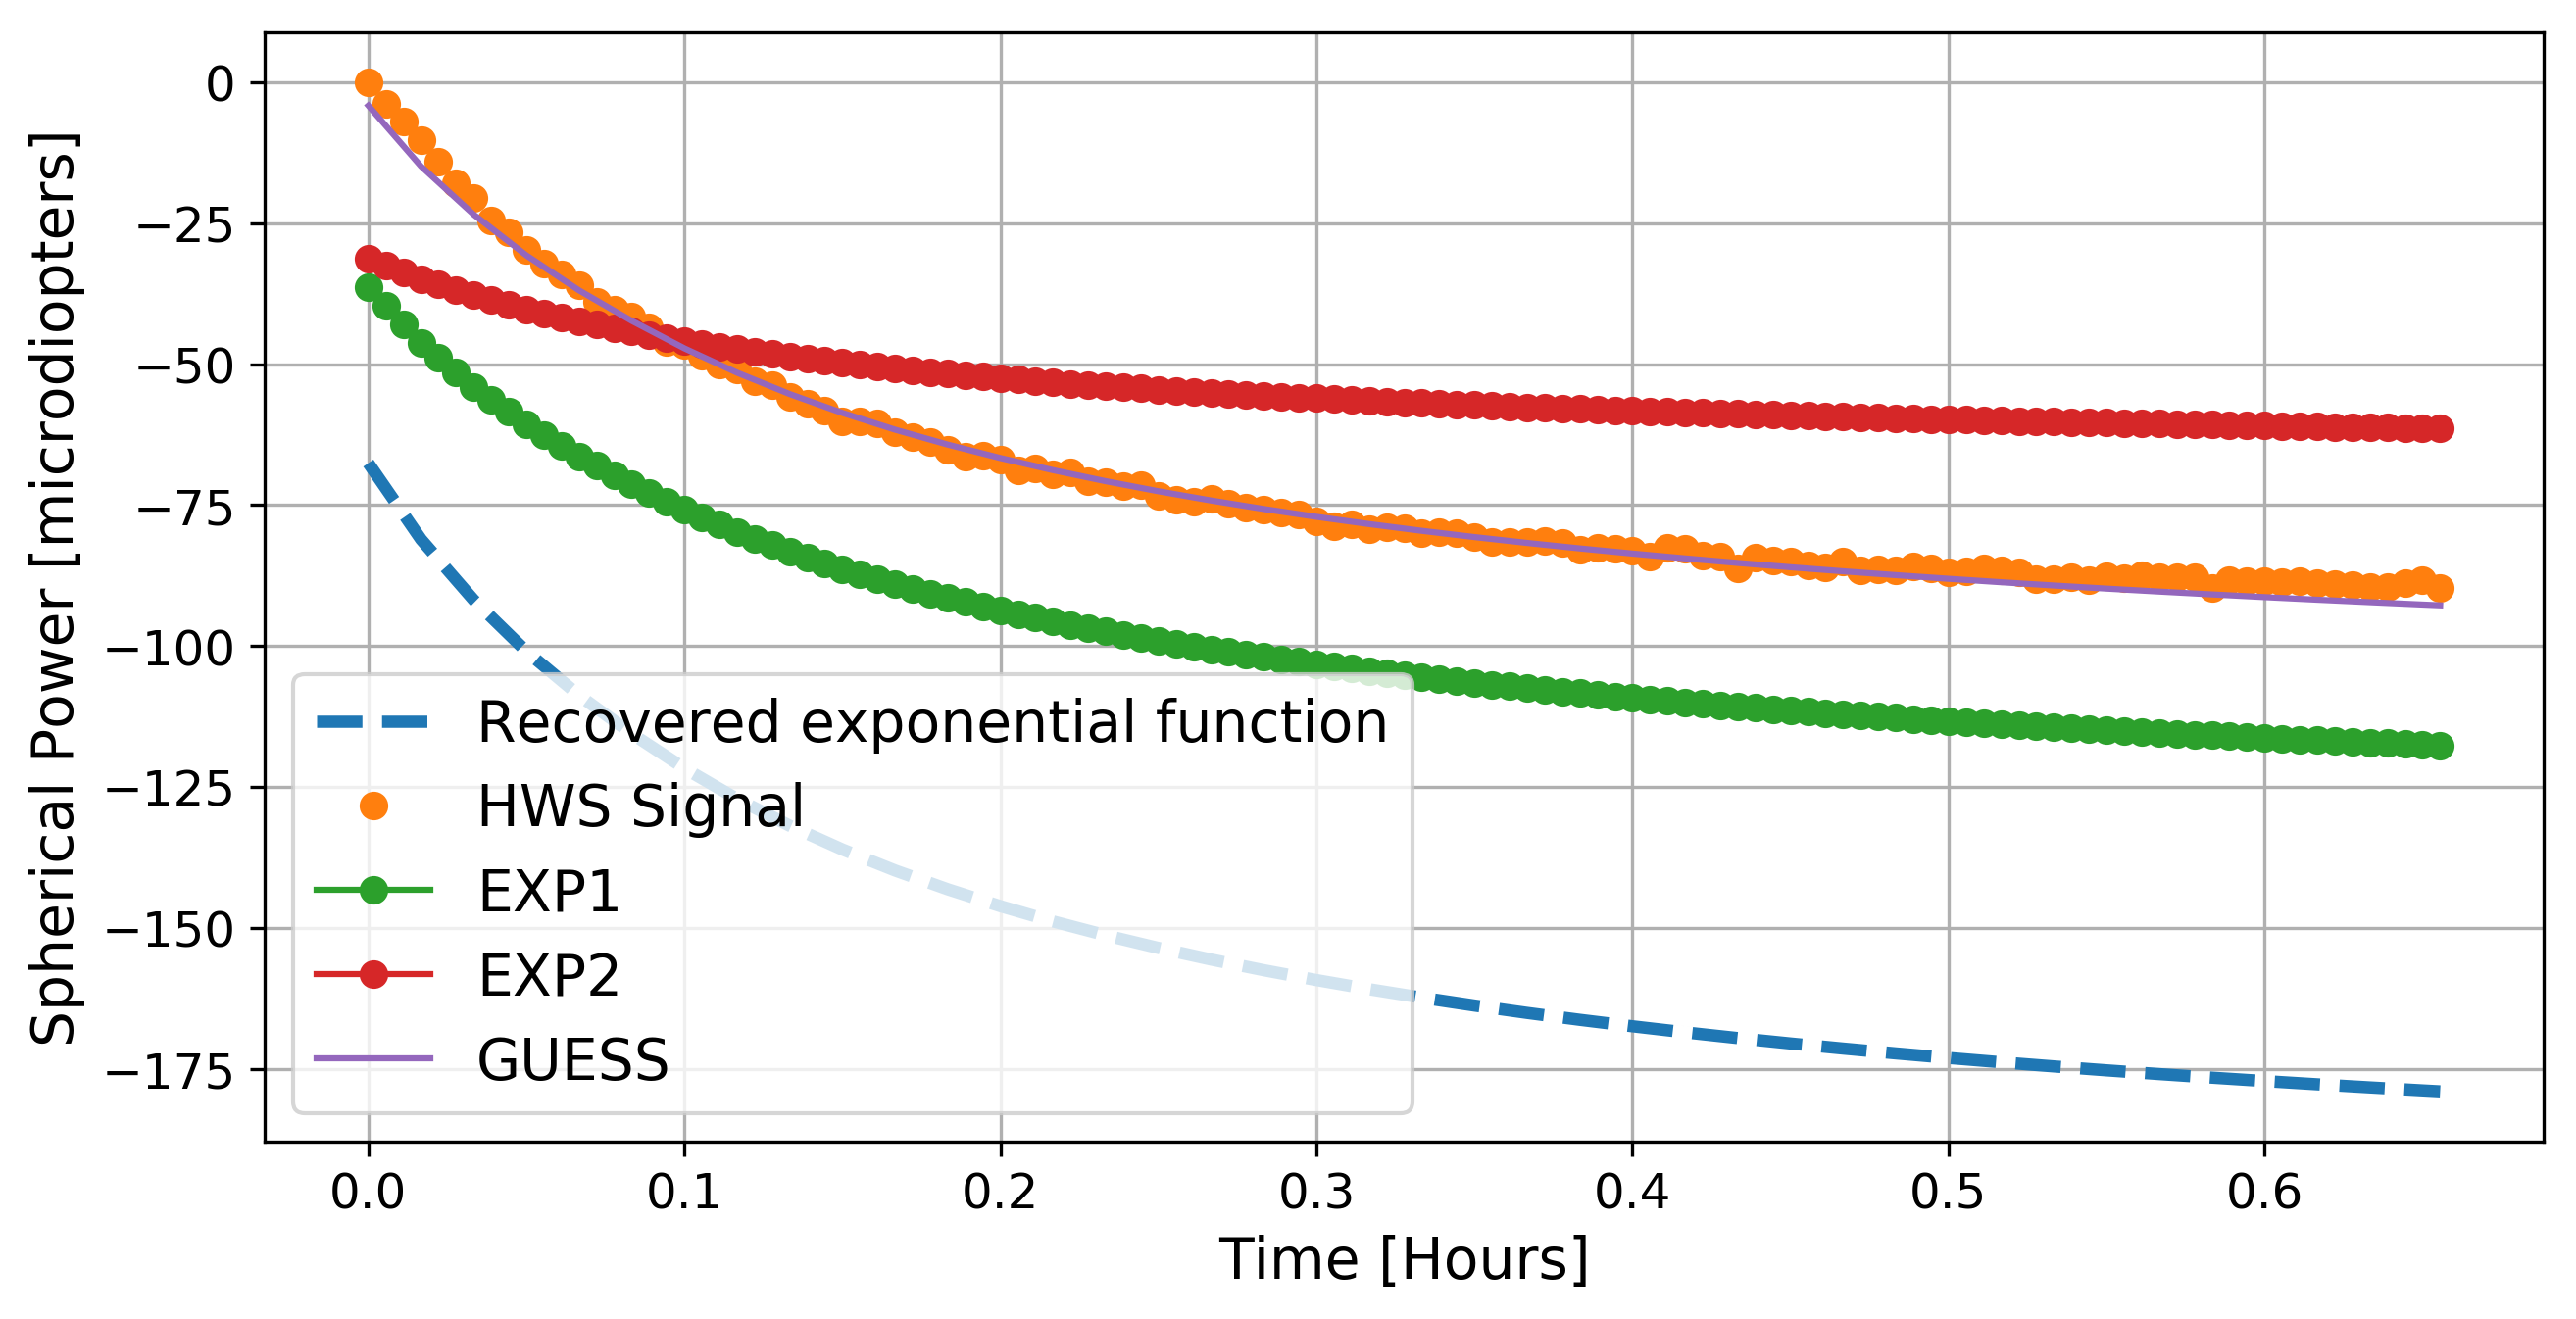

In [297]:

plot_results(time_y,data_y,results_y,'MCMC_ITMY_ABS_FIT.png')